In [1]:
import numpy as np
import pandas as pd

import os, nltk, string, gensim, warnings, pickle

from nltk.corpus import stopwords
from nltk.tokenize import word_tokenize 

from sklearn.model_selection import train_test_split
from sklearn.feature_extraction.text import CountVectorizer, TfidfVectorizer

from sklearn import preprocessing, ensemble, metrics
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt

In [2]:
def csvtotext(df):
  text = df.to_csv(sep=' ', index=False, header=False).lower()
  return(text)

In [3]:
def cleantext(text):
    full_tokens = word_tokenize(text)
    tokens = [word for word in full_tokens if word.isalpha()]
    tokens = [word for word in tokens if len(word)>1]        
    return(full_tokens, tokens)

In [4]:
def word_freq_analyser(tokens):
    freq = nltk.FreqDist(tokens)
    freqdf = pd.DataFrame.from_dict(freq,orient='index')
    freqdf = freqdf.reset_index()
    freqdf = freqdf.rename(columns={'index' : 'word', 0:'count'})
    freqdf = freqdf.sort_values(by = ['count'], ascending = False)
    freqdf = freqdf.reset_index(drop=True)
    freqdf = freqdf.reset_index()
    freqdf = freqdf.rename(columns={'index' : 'sno'})
    freqdf['sno'] = freqdf['sno'] + 1
    freqdf['distinct_word_%'] = freqdf['sno']/len(freqdf['sno']) * 100
    freqdf['cumsum'] = freqdf['count'].cumsum()
    freqdf['corpus_%'] = freqdf['cumsum'] / freqdf['count'].sum() * 100
    
    freqdf['distinct_word_%'] = np.round(freqdf['distinct_word_%'], 0)
    freqdf['corpus_%'] = np.round(freqdf['corpus_%'], 0)
    
    small_freq_df = freqdf.drop_duplicates(subset=['corpus_%'], keep = 'first')
    
    return(freqdf, small_freq_df)    

In [5]:
def plot_reverse_elbow_curve(small_freq_df):
    x = small_freq_df['distinct_word_%']
    y = small_freq_df['corpus_%']

    fig, ax = plt.subplots()
    fig.set_size_inches(15, 5)


    ax.plot(x, y, **{'color': 'lightsteelblue', 'marker': 'o'})
    plt.xticks(np.arange(min(x), 100, 2))
    plt.yticks(np.arange(min(y), 100, 10))
    plt.xlabel ('distinct_word_%')
    plt.ylabel ('corpus_%')
    return(plt)

In [6]:
def create_report_df(small_freq_df, freqdf):
    df_report = pd.DataFrame()
    imp_deciles = list(np.arange(75,101,5))
    num_of_words = []
    perc_of_dist_words = []

    for dec in imp_deciles:
        perc_of_dist_words.append(small_freq_df[small_freq_df['corpus_%'] == dec].reset_index()['distinct_word_%'][0])
        num_of_words.append(small_freq_df[small_freq_df['corpus_%'] == dec].reset_index()['sno'][0])

    df_report['num_of_words'] = num_of_words
    df_report['dist_words%'] = perc_of_dist_words
    df_report['corpus%'] = imp_deciles
    report1 = f'1. Most frequent {df_report["num_of_words"][0]} unique words, which are {df_report["dist_words%"][0]}% of the total distinct words, are contributing to the {df_report["corpus%"][0]}% of the total corpus.'
    
    dist_word_count_90 = small_freq_df[small_freq_df['corpus_%'] == 90].reset_index()['sno'][0]
    dist_word_count_100 = freqdf['sno'].iloc[-1]
    dist_word_90_100 = dist_word_count_100 - dist_word_count_90
    dist_word_bottom_perc = np.round((dist_word_90_100 / dist_word_count_100)*100,1)
    report2 = f'2. Least frequent {dist_word_90_100} unique words, which are {dist_word_bottom_perc}% of the total distinct words, are contributing only to the bottom 10% of the total corpus.'

    print("---------------------------------- Analysis Results ----------------------------------")
    print(report1)
    print(report2)
    print("--------------------------------------------")
    print(df_report)
    print("--------------------")
    print('num_of_words : Distinct count of Top-most frequent words')
    print('dist_words%  : num_of_words / total distinct words in corpus')
    print('corpus%      : Total count of num_of_words / Total number of words in corpus')
    print("--------------------------------------------")
    return(df_report)

In [7]:
def dynamic_stop_word_analyzer(tokens):
    freqdf, small_freq_df = word_freq_analyser(tokens)
    plt = plot_reverse_elbow_curve(small_freq_df) 
    df_report = create_report_df(small_freq_df, freqdf)
    return(freqdf, small_freq_df, df_report)

In [8]:
def get_dynamic_stop_words_list(freqdf, corpus_perc_threshold):
    dynamic_stop_words_list = list(freqdf[freqdf['corpus_%'] >= corpus_perc_threshold]['word'])    
    return(dynamic_stop_words_list)

In [9]:
#...............................................................................................    
def send_telegram_message(message_text):  
    data = {}
    import requests
    chat_id = "-773311834"
    tester_bot_token = "5237058133:AAH3KdHe4sh95aHrZJXWyTjNxBbUjQAqi4U"
    data['telegram_url'] = "https://api.telegram.org/bot"
    data['url_for_Chat_id'] = f'{tester_bot_token}/getUpdates'   
    
    send_message_url = f'{data["telegram_url"]}{tester_bot_token}/sendMessage?chat_id={chat_id}/&text={message_text}'
    requests.get(send_message_url)
#...............................................................................................  

In [10]:
def create_tokens_list_of_list(tokens):   
        
    sentence = []
    message = []
    for word in tokens:
        if word != '§':
            sentence.append(word)
        if word == '§':
            message.append(sentence)
            sentence = []
    
    joined_message = [' '.join(x) for x in message]    
    return(message, joined_message)

In [11]:
def remove_stop_words(full_tokens, stop_list):            
    
    tokens = [word for word in full_tokens if word == "§" or word.isalpha()]
    tokens = [word for word in tokens if word == "§" or len(word)>1]
    tokens = [word for word in tokens if word == "§" or not word in stop_list]
    return(tokens)

In [12]:
def tfvect(df, train_x, valid_x):
    tf_vect = TfidfVectorizer(max_df = 1.0, min_df = 1)
    tf_vect.fit(df['reduced_tweet'])

    train_x_tf =  tf_vect.transform(train_x)
    valid_x_tf =  tf_vect.transform(valid_x)
  
#     pd.DataFrame(train_x_tf.A, columns=tf_vect.get_feature_names()).to_csv('tf_vect.csv')
#     pickle.dump(tf_vect.vocabulary_,open("tffeatures.pkl","wb"))
    
    return(train_x_tf,valid_x_tf)

In [13]:
def countvect(df, train_x, valid_x):
    count_vect = CountVectorizer(max_df = 1.0, min_df = 1)
    count_vect.fit(df['reduced_tweet'])

    train_x_cv =  count_vect.transform(train_x)
    valid_x_cv =  count_vect.transform(valid_x)

    #pd.DataFrame(train_x_cv.A, columns=count_vect.get_feature_names()).to_csv('count_vect.csv')
    
    return(train_x_cv,valid_x_cv,count_vect)

In [14]:
def encodelabel(train_y,valid_y):
    encoder = preprocessing.LabelEncoder()
    train_y_count = encoder.fit_transform(train_y)
    valid_y_count = encoder.fit_transform(valid_y)

    train_y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))
    valid_y_map = dict(zip(encoder.transform(encoder.classes_),encoder.classes_))

    print('train_y_map :',train_y_map,)
    print('valid_y_map :',valid_y_map)
    
    return(train_y_count, train_y_map, valid_y_count, valid_y_map)

In [15]:
df = pd.read_csv('data/Corona_NLP_train.csv', encoding = "ISO-8859-1")

df.loc[df['Sentiment'] == 'Extremely Negative', 'Sentiment'] = 'Negative'
df.loc[df['Sentiment'] == 'Extremely Positive', 'Sentiment'] = 'Positive'

df = df[['OriginalTweet', 'Sentiment']]
df['OriginalTweet'] = df['OriginalTweet'] + " § "

In [16]:
text = csvtotext(df['OriginalTweet'])
full_tokens, tokens = cleantext(text)

---------------------------------- Analysis Results ----------------------------------
1. Most frequent 859 unique words, which are 2.0% of the total distinct words, are contributing to the 75% of the total corpus.
2. Least frequent 45536 unique words, which are 92.0% of the total distinct words, are contributing only to the bottom 10% of the total corpus.
--------------------------------------------
   num_of_words  dist_words%  corpus%
0           859          2.0       75
1          1347          3.0       80
2          2204          4.0       85
3          3961          8.0       90
4          9206         19.0       95
5         43746         88.0      100
--------------------
num_of_words : Distinct count of Top-most frequent words
dist_words%  : num_of_words / total distinct words in corpus
corpus%      : Total count of num_of_words / Total number of words in corpus
--------------------------------------------


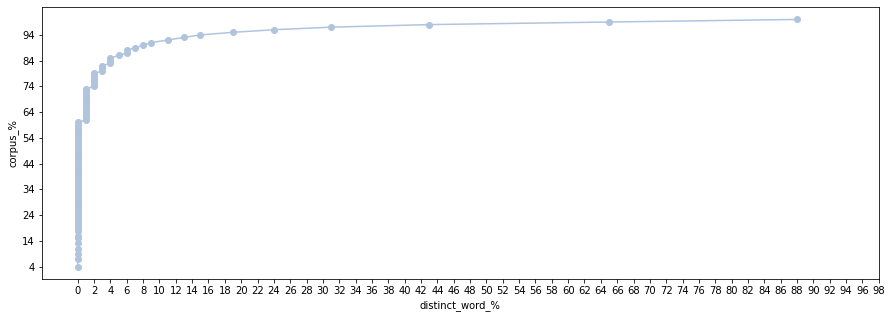

In [17]:
freqdf, small_freq_df, df_report = dynamic_stop_word_analyzer(tokens)

In [18]:
corpus_perc_threshold = 90

dynamic_stop_words_list = get_dynamic_stop_words_list(freqdf, corpus_perc_threshold)

tokens = remove_stop_words(full_tokens, dynamic_stop_words_list)
message, joined_message = create_tokens_list_of_list(tokens)

### Modelling

In [19]:
%%time
nltk_stopwords = stopwords.words('english')

tokens = remove_stop_words(full_tokens, nltk_stopwords)
message, joined_message = create_tokens_list_of_list(tokens)

Wall time: 1.98 s


In [20]:
df['reduced_tweet'] = joined_message
# df[-100:].to_csv('data/temp.csv')
# send_telegram_message('run complete')

In [21]:
train_x, valid_x, train_y, valid_y = train_test_split(df['reduced_tweet'], df['Sentiment'],train_size = 0.8,random_state = 1)

In [22]:
train_y_count, train_y_map, valid_y_count, valid_y_map = encodelabel(train_y,valid_y)

train_y_map : {0: 'Negative', 1: 'Neutral', 2: 'Positive'}
valid_y_map : {0: 'Negative', 1: 'Neutral', 2: 'Positive'}


In [23]:
%%time
train_x_tf, valid_x_tf = tfvect(df, train_x, valid_x)
clf = ensemble.RandomForestClassifier().fit(train_x_tf, train_y_count)
predictions = clf.predict(valid_x_tf)
acc = metrics.accuracy_score(predictions, valid_y_count)   
acc

Wall time: 2min 12s


0.7354227405247813

In [24]:
%%time
train_x_cv, valid_x_cv, cvect = countvect(df, train_x, valid_x)
clf = ensemble.RandomForestClassifier().fit(train_x_cv, train_y_count)
predictions = clf.predict(valid_x_cv)   
acc = metrics.accuracy_score(predictions, valid_y_count)   
acc

Wall time: 2min 21s


0.749514091350826

# --------------------------------------------

In [ ]:
%%time
nltk_stopwords = stopwords.words('english')

tokens = remove_stop_words(full_tokens, nltk_stopwords)
tokens = remove_stop_words(tokens, dynamic_stop_words_list)
message, joined_message = create_tokens_list_of_list(tokens)

In [ ]:
df['reduced_tweet'] = joined_message
# df[-100:].to_csv('data/temp.csv')
# send_telegram_message('run complete')

In [ ]:
train_x, valid_x, train_y, valid_y = train_test_split(df['reduced_tweet'], df['Sentiment'],train_size = 0.8,random_state = 1)

In [ ]:
train_y_count, train_y_map, valid_y_count, valid_y_map = encodelabel(train_y,valid_y)

In [ ]:
%%time
train_x_tf, valid_x_tf = tfvect(df, train_x, valid_x)
clf = ensemble.RandomForestClassifier().fit(train_x_tf, train_y_count)
predictions = clf.predict(valid_x_tf)    
acc = metrics.accuracy_score(predictions, valid_y_count)   
acc

In [ ]:
%%time
train_x_cv, valid_x_cv, cvect = countvect(df, train_x, valid_x)
clf = ensemble.RandomForestClassifier().fit(train_x_cv, train_y_count)
predictions = clf.predict(valid_x_cv)   
acc = metrics.accuracy_score(predictions, valid_y_count)   
acc